#Project

In today's rapidly evolving job market, finding the right career path can be daunting. That's why we've developed a personalized career pathing solution powered by advanced AI algorithms and comprehensive data analysis. 
Inspired by insights from platforms like LinkedIn and Glassdoor, our project aims to answer a crucial question: Can we predict an individual's optimal career path using AI-driven analysis of their personal attributes and current job market data? 

This project addresses the critical need for tailored career guidance in an increasingly complex professional landscape, offering individuals clarity and confidence in their career decisions.

##Initialization:

In [0]:
from pyspark.sql.types import *
import pyspark
from nltk.corpus import stopwords
from pyspark.sql import SparkSession
# Standard library imports
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px

# NLTK imports
from nltk.corpus import stopwords

# PySpark imports
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import (
    col, struct, explode, lower, regexp_extract, countDistinct, length, udf, size, mean, desc, split, collect_list ,count, sum as sum_ ,avg, rank
)
from pyspark.sql.types import (
    StructType, StructField, StringType, ArrayType, FloatType, BooleanType, IntegerType
)
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import col, expr, when, split, row_number,dense_rank, regexp_replace
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import udf, percentile_approx
from pyspark.sql.functions import col, lit
import matplotlib.pyplot as plt



spark = SparkSession.builder.getOrCreate()

In [0]:
profiles = spark.read.parquet('/linkedin/people')
companies = spark.read.parquet('/linkedin/companies')

In [0]:
df_profiles = profiles
df_companies = companies

##Data Scraping:


A web scraping script was developed using Python's Selenium and BeautifulSoup libraries. The script navigates through Glassdoor's website, specifically targeting job listings.
Selenium was utilized to automate the web browsing process, while BeautifulSoup facilitated the extraction of relevant information from the HTML content.


The code was ran locally using Google Colab:

In [0]:
from requests import get
from bs4 import BeautifulSoup
from IPython.core.display import clear_output
from selenium.webdriver import Remote, ChromeOptions
from selenium.webdriver.chromium.remote_connection import ChromiumRemoteConnection
from selenium.webdriver.common.by import By
import time
from selenium.webdriver import Chrome
from selenium.webdriver.chrome.options import Options

SBR_WEBDRIVER = ''


print('Connecting to Scraping Browser...')
sbr_connection = ChromiumRemoteConnection(SBR_WEBDRIVER, 'goog', 'chrome')

itemsPerLevel = []

links = []
minRating = ''

# Change to link after industry search
link = 'https://www.glassdoor.com/Job/united-states-media-jobs-SRCH_IL.0,13_IN1_KO14,19.htm'
links.append(link + "?seniorityType=internship" + minRating)
links.append(link + "?seniorityType=entrylevel" + minRating)
links.append(link + "?seniorityType=midseniorlevel" + minRating)
links.append(link + "?seniorityType=director" + minRating)
links.append(link + "?seniorityType=executive" + minRating)

for i in range(5):
  empty = True
  while empty :
        job_items = []
        with Remote(sbr_connection, options=ChromeOptions()) as driver:
            driver.get(links[i])
            print('Navigated! Scraping page content...')
            show_more_button = driver.find_elements(By.XPATH, '//button[normalize-space()="Show more jobs"]')
            if show_more_button:
               show_more_button[0].click()
               time.sleep(5)
               button_found = driver.find_elements(By.CLASS_NAME, "CloseButton")
               if button_found:
                  button_found[0].click()
                  time.sleep(5)

            show_more_button = driver.find_elements(By.XPATH, '//button[normalize-space()="Show more jobs"]')
            if show_more_button:
               show_more_button[0].click()
               time.sleep(5)

            html = driver.page_source

        soup = BeautifulSoup(html, 'html.parser')
        job_items = soup.find_all('li', class_='JobsList_jobListItem__wjTHv')
        if len(job_items) == 0 : continue
        else :
          itemsPerLevel.append(job_items)
          empty = False
          break


In [0]:
import pandas as pd

df = pd.DataFrame(columns=['Company Name', 'Rating', 'Job Name', 'Job Salary'])

for i in range(5):
    company_names = []
    ratings = []
    job_names = []
    job_salaries = []

    for job_item in itemsPerLevel[i]:
        if job_item.find('span' , class_ = 'EmployerProfile_compactEmployerName__LE242') == None :
          company_names.append(None)
          continue
        else :
          company_name = job_item.find('span' , class_ = 'EmployerProfile_compactEmployerName__LE242').text
          company_names.append(company_name)

    for job_item in itemsPerLevel[i]:
        if job_item.find('div' , class_ = 'EmployerProfile_ratingContainer__ul0Ef') == None :
          ratings.append(None)
          continue
        else :
          rating = job_item.find('div' , class_ = 'EmployerProfile_ratingContainer__ul0Ef').text
          ratings.append(rating)

    for job_item in itemsPerLevel[i]:
        if job_item.find('a' , class_ = 'JobCard_jobTitle___7I6y') == None :
          job_names.append(None)
          continue
        else :
          job_name = job_item.find('a' , class_ = 'JobCard_jobTitle___7I6y').text
          job_names.append(job_name)

    for job_item in itemsPerLevel[i]:
        if job_item.find('div' , class_ = 'JobCard_salaryEstimate__arV5J') == None :
          job_salaries.append(None)
          continue
        else :
          job_salary = job_item.find('div' , class_ = 'JobCard_salaryEstimate__arV5J').text
          job_salaries.append(job_salary)

          if i == 0 :
            level = "Internship"
          elif i == 1:
            level = "Entry Level"
          elif i == 2:
            level = "Mid Senior"
          elif i == 3:
            level = "Director"
          elif i == 4:
            level = "Executive"

    data = {
        'Company Name': company_names,
        'Rating': ratings,
        'Job Name': job_names,
        'Job Salary': job_salaries,
    }
    # Change this to new industry name
    data['Industry'] = 'Media and Entertainment'
    data['level'] = level

    df = df.append(pd.DataFrame(data), ignore_index=True)

#change name of csv to data_'industry'
filename = 'data_Media.csv'
df.to_csv(filename, index=False)

**After scraping the data and storing it into csv, we uploaded the csv file of all the scraped data to the DBFS.** 

In [0]:
scraped_data = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/luay.m@campus.technion.ac.il/scraped_data.csv")

The Scraped Data :

In [0]:
scraped_data.show()

+--------------------+------+--------------------+--------------------+-------------+----------+
|        Company Name|Rating|            Job Name|          Job Salary|     Industry|     level|
+--------------------+------+--------------------+--------------------+-------------+----------+
|MRS GERRYS KITCHE...|   4.2|Summer Production...|$18.40 Per Hour (...|manufacturing|Internship|
|MRS GERRYS KITCHE...|   4.2|Summer Production...|$18.00 Per Hour (...|manufacturing|Internship|
|       Soccer Master|   4.3|Summer Production...|$15.00 Per Hour (...|manufacturing|Internship|
|       Soccer Master|   4.3|Summer Production...|$15.00 Per Hour (...|manufacturing|Internship|
|Charter Next Gene...|   3.9|Production Team M...|$29K - $39K (Glas...|manufacturing|Internship|
|  Metal Technologies|   4.0|General Factory -...|$29K - $47K (Glas...|manufacturing|Internship|
|The Boston Beer C...|   4.1| Manufacturing CO-OP|$38K - $54K (Glas...|manufacturing|Internship|
|The Boston Beer C...|   4.1|Q

##Preprocessing the Scraped Data:

**Finding Missing Values:**

In [0]:
from pyspark.sql.functions import col

total_rows = scraped_data.count()

def print_missing_percentage(column_name, null_count):
    missing_percentage = (null_count / total_rows) * 100
    print(f"Missing percentage for '{column_name}': {missing_percentage:.2f}%")

null_company_name = scraped_data.filter(col('Company Name').isNull())
print_missing_percentage('Company Name', null_company_name.count())

null_rating = scraped_data.filter(col('Rating').isNull())
print_missing_percentage('Rating', null_rating.count())

null_job_name = scraped_data.filter(col('Job Name').isNull())
print_missing_percentage('Job Name', null_job_name.count())

null_job_salary = scraped_data.filter(col('Job Salary').isNull())
print_missing_percentage('Job Salary', null_job_salary.count())

null_Industry = scraped_data.filter(col('Industry').isNull())
print_missing_percentage('Industry', null_Industry.count())

null_level = scraped_data.filter(col('level').isNull())
print_missing_percentage('level', null_level.count())


Missing percentage for 'Company Name': 1.23%
Missing percentage for 'Rating': 4.40%
Missing percentage for 'Job Name': 1.23%
Missing percentage for 'Job Salary': 10.40%
Missing percentage for 'Industry': 0.00%
Missing percentage for 'level': 0.00%


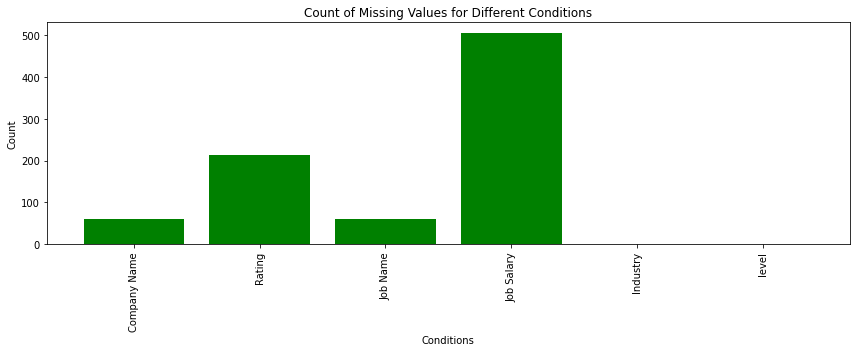

In [0]:
import matplotlib.pyplot as plt

conditions = {
    "Company Name": null_company_name.count(),
    "Rating": null_rating.count(),
    "Job Name": null_job_name.count(),
    "Job Salary": null_job_salary.count(),
    "Industry": null_Industry.count(),
    "level": null_level.count(),
}

plt.figure(figsize=(12, 5))
plt.bar(conditions.keys(), conditions.values(), color='green')
plt.xticks(rotation=90)
plt.xlabel('Conditions')
plt.ylabel('Count')
plt.title('Count of Missing Values for Different Conditions')
plt.tight_layout()
plt.show()

**Handling Missing Null Rows:**

While scraping Glassdoor we extracted multiple null rows , so we will drop them because they serve no purpose.

In [0]:
scraped_data = scraped_data.distinct()

df_without_nulls = scraped_data.filter(col('Company Name').isNotNull() & col('Rating').isNotNull() & col('Job Name').isNotNull())
final_scraped = df_without_nulls

**Data cleaning**

Now we will clean the column 'Job Salary', because its values are strings with very complex patterns , so we have to extract the right numbers 

We also had to pay attention to salaries calculated by the hour and yearly

In [0]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import re

def clean_salary(salary):
    if salary:
        parts = salary.split()
        cleaned = []
        for part in parts:
            if part == "Per" and "Hour" in parts[parts.index(part):]:
                cleaned.append("Per Hour")
                break
            cleaned.append(part)
        return ' '.join(cleaned).replace('(Employer est.)', '').replace('(Glassdoor est.)', '')
    else:
        return None

clean_salary_udf = F.udf(clean_salary)

final_scraped = final_scraped.withColumn("Job Salary", clean_salary_udf("Job Salary"))

In [0]:
def calc(salary):
    if salary is None:
        return None
    
    numbers = re.findall(r'\d+(?:\.\d+)?', salary)
    nums = [float(num) if '.' in num else int(num) for num in numbers]
    if "Per Hour" in salary:
        if "-" in salary :
            return (((nums[0] + nums[1]) / 2) * 42 * 50) / 1000
        else:
            return (nums[0] * 42 * 50) / 1000
    else:
        if "-" in salary :
            return ((nums[0] + nums[1]) / 2)
        else :
            return nums[0]
        
final_salary_udf = F.udf(calc)
final_scraped = final_scraped.withColumn("Job Salary", final_salary_udf("Job Salary"))

**Handling Null Salaries:**

**Null values inside this column had to be handled , so we decided to replace the null values by the average salary of the relevant Industry**

In [0]:
average_salary_by_industry = final_scraped.groupBy('Industry').agg(avg('Job Salary').alias('Average Job Salary'))

joined_df = final_scraped.join(average_salary_by_industry, on='Industry', how='inner')
joined_df = joined_df.withColumn('Job Salary', when(joined_df['Job Salary'].isNull(), joined_df['Average Job Salary']).otherwise(joined_df['Job Salary']))

final_scraped = joined_df.select("Company Name", "Rating" ,"Job Name", "Job Salary" , "Industry" , "level")

final_scraped = final_scraped.withColumn("Rating", col("Rating").cast("float"))
final_scraped = final_scraped.withColumn("Job Salary", col("Job Salary").cast("float"))

**Cleaned Scraped Data :**

In [0]:
final_scraped.show()

+--------------------+------+--------------------+----------+--------------------+-----------+
|        Company Name|Rating|            Job Name|Job Salary|            Industry|      level|
+--------------------+------+--------------------+----------+--------------------+-----------+
|            PM Group|   4.3|Co-op Process Eng...|     126.5|       manufacturing| Internship|
|            Wildtype|   4.5|Bioprocess Manufa...|      89.0|       manufacturing| Mid Senior|
|                 EPM|   4.4|Director Of Mortg...|      70.0|       manufacturing|   Director|
|     Hewlett Packard|   4.1|Global Head of Co...|     188.0|Media and Enterta...|  Executive|
|    Sweetwater Sound|   3.6|Head of Social Media|      65.0|Media and Enterta...|  Executive|
|Preventative care...|   5.0| Facility Supervisor|      30.0|            Services| Mid Senior|
|Work Services Cor...|   4.0|Attendant II - Ha...|      21.0|            Services| Mid Senior|
|         GT Electric|   5.0|Electrical Forema...|

##Data Analysis

Data analysis is a critical process for extracting insights from raw data. In this part, we outline the analysis techniques, feature selection methods, and visualizations used in our data analysis.

In this section we will go through all the different methods we used in order to choose the right columns as features for our prediction model. 

**Through this journey we always kept an eye on our main goal which is classifying the person's seniority level and the industry he belongs to**

First we decided to start researching column 'position' , and the reason is because this column gives us valuable and rich information about the person's current status in the market

We will examine the possible relation between the state that the person lives in and the current job position he has.

In [0]:
brc = df_profiles

brc = brc.withColumn("state", regexp_extract(col("city"), r",\s*([A-Za-z ]+),\s*United States", 1))
brc = brc.filter(length(col("state")) > 0)
brc = brc.filter(col("state") != "District of Columbia")
brc = brc.withColumn("mentions_business", lower(col("position")).contains("art"))
business_mentions_per_state = brc.filter(col("mentions_business")) \
                                      .groupBy("state") \
                                      .agg(countDistinct("url").alias("unique_business_mentions"))

business_mentions_per_state.collect()
df = business_mentions_per_state.toPandas()

state_abbreviations = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA',
    'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH',
    'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC',
    'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA',
    'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN',
    'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA',
    'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
}

df['state'] = df['state'].map(state_abbreviations)

fig = px.choropleth(df, 
                    locations='state', 
                    locationmode="USA-states", 
                    color='unique_business_mentions',
                    color_continuous_scale='Reds',
                    scope="usa",
                    title='Business Mentions by State')

fig.show()

And we can see that some states have higher number of people who work in art in their current position, so that means that the location of the person gives us some information about his field to some extinct

In order to build an optimal career path for each profile, first we need to know the seniority level he is currently at , then we could build a suitable path that matches his seniority level.

By understanding the domain of the data , we decided to dive deeper into the 'position' column.

This column describes the current position of the person , and by using this column we can extract valuable info about the seniority level of the person.

In [0]:
from pyspark.sql.functions import col

num_of_nulls = df_profiles.filter(col('position').isNull() | (col('position') == '--') ).count()
print("Percentage of missing values in column 'position' : ")
print((num_of_nulls / df_profiles.count()) * 100)

# rows_with_position = df_profiles.filter(col('position').isNotNull() & (col('position') != '--')).select('position')
rows_with_position = df_profiles.filter(col('position').isNotNull() & (col('position') != '--'))

Percentage of missing values in column 'position' : 
26.52042434342588


Now in order for our prediction model to work well , we had to find a way to build a train set, that has true labels that we could rely on.

Through the identification of specific keywords within the 'position' column, we have successfully labeled a sufficient amount of labeled train data for our model :

In [0]:
def categorize_seniority(position):
    position_lower = position.lower()
    if any(word in position_lower for word in ["senior", "lead", "principal", "chief", "director", "vice president", "manager", "supervisor"]):
        return "Director"
    elif any(word in position_lower for word in ["intern", "student", "trainee", "apprentice", "junior"]):
        return "Internship"
    elif any(word in position_lower for word in ["entry-level", "assistant", "associate", "entry level", "associate's", "assistant's"]):
        return "Entry Level"
    elif any(word in position_lower for word in ["owner", "entrepreneur", "ceo", "president", "partner", "founder", "proprietor"]):
        return "Executive"
    elif any(word in position_lower for word in ["retired"]):
        return "retired"
    else:
        return "Mid Senior"


categorize_seniority_udf = udf(categorize_seniority, StringType())

rows_with_position = rows_with_position.withColumn("seniority_level", categorize_seniority_udf(rows_with_position["position"]))



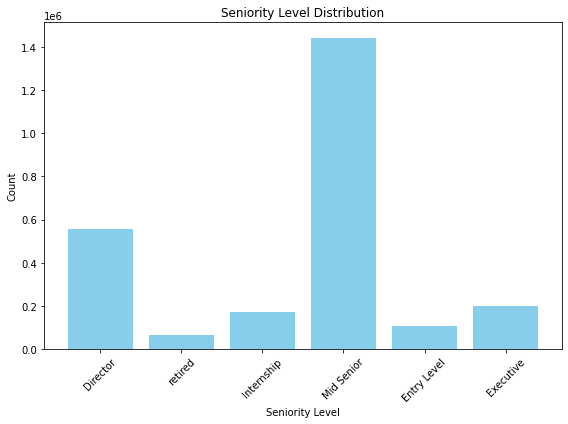

In [0]:
import matplotlib.pyplot as plt

seniority_levels = rows_with_position.rdd.map(lambda x: x['seniority_level'])

seniority_counts = seniority_levels.countByValue()

levels = list(seniority_counts.keys())
counts = list(seniority_counts.values())

plt.figure(figsize=(8, 6))
plt.bar(levels, counts, color='skyblue')
plt.title('Seniority Level Distribution')
plt.xlabel('Seniority Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**It does make sense because almost in every industry in the job market , the mid senior level is the most common.**

Now what about people with no current Position ?

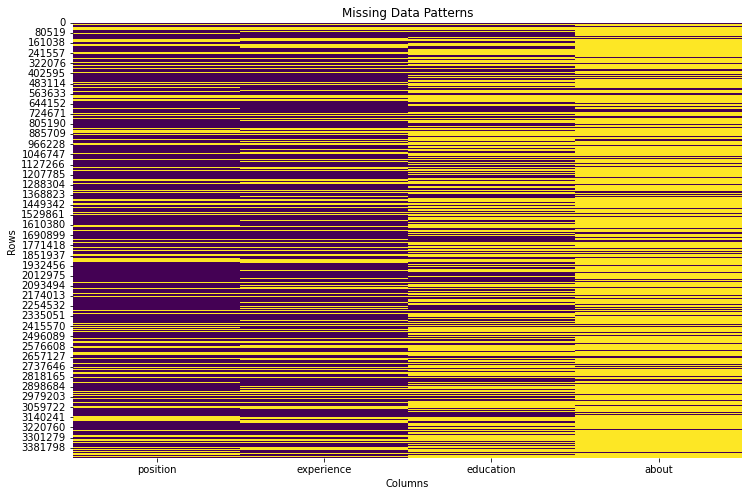

In [0]:
import seaborn as sns

missing_conditions = {
    "position": col('position').isNull(),
    "experience": size(col('experience')) == 0,
    "education": size(col('education')) == 0,
    "about": col('about').isNull(),
}

cookie = df_profiles.select('position','experience','education','about')
cookie = cookie.withColumn("position", when(cookie["position"] == "--", None).otherwise(cookie["position"]))
missing_data = cookie.select([missing_conditions[c].alias(c) for c in cookie.columns]).toPandas()

plt.figure(figsize=(12, 8))
sns.heatmap(missing_data, cmap='viridis', cbar=False)
plt.title('Missing Data Patterns')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

**And we could clearly see that there might be some pattern where most of the people with no current position also have no any other inforamtion that could help us build a carrer path**

Number of people with no current position :

In [0]:
null_position = df_profiles.filter(col('position').isNull() | (col('position') == '--')).select('position')

print(null_position.count())

918214


Now we interested in people with no current position and with no any other information:

In [0]:
null_position_experience = null_position.filter(size(col('experience')) == 0)
null_position_experience_education = null_position_experience.filter(size(col('education')) == 0)
courses = df_profiles.columns[-1]
null_position_experience_education_courses = null_position_experience_education.filter(size(col(courses)) == 0)
null_position_experience_education_courses_about = null_position_experience_education_courses.filter(col('about').isNull())
print(null_position_experience_education_courses_about.count())


796433


We got a very important finding :
796433 profiles has no concrete info in all the following columns : position ,experience , education , courses and about.

So these profiles have no data we could use for crafting a proper carrer path 

**A potential solution for people with no information at all ,could involve LinkedIn sending targeted notifications encouraging individuals to enhance their profiles with more comprehensive details, thus enabling them to maximize their potential**

Now we will continue analyzing other columns

The "about" column contains numerous hidden insights into an individual's characteristics that are valuable :

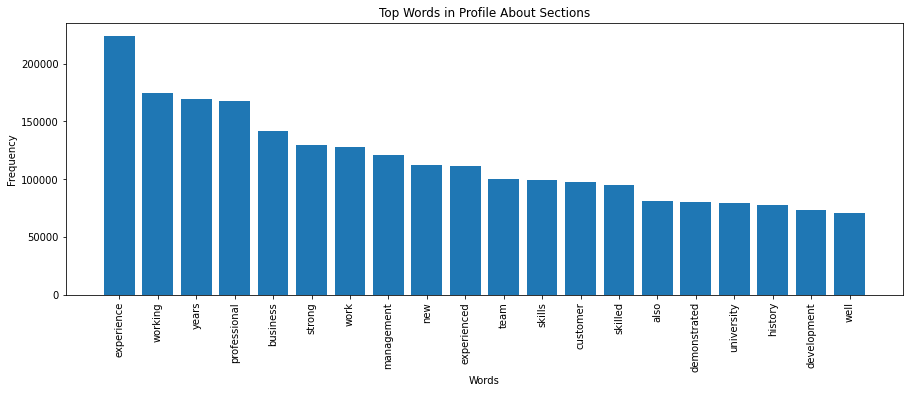

In [0]:
from nltk.corpus import stopwords
english_stopwords = stopwords.words('english')
stopwords_string = ' '.join(english_stopwords)
stopWords = set(stopwords_string.split())

def clean_text(text):
    if text is not None:
        stop_words = stopWords
        words = text.lower().split()
        return list(set(word for word in words if word.isalpha() and word not in stop_words))
    else:
        return []

clean_text_udf = udf(clean_text, ArrayType(StringType()))
profiles_cleaned = profiles.withColumn("cleaned_about", clean_text_udf(col("about")))
word_counts = profiles_cleaned.select(explode(col("cleaned_about")).alias("word")).groupBy("word").count()
word_counts_list = word_counts.collect()
profile_word_counts = Counter({row['word']: row['count'] for row in word_counts_list})
top_N = 20
most_common_words = profile_word_counts.most_common(top_N)
words, counts = zip(*most_common_words)

plt.figure(figsize=(15, 5))
plt.bar(words, counts)
plt.xlabel('Words')
plt.xticks(rotation='vertical')
plt.ylabel('Frequency')
plt.title('Top Words in Profile About Sections')
plt.show()

Overall individuals tend to highlight their professional experience, skill set, and work ethic , and those factors could really help us knowing the industry that they belong to 

We will look into the possible relation between 'about' column and number of experience years :

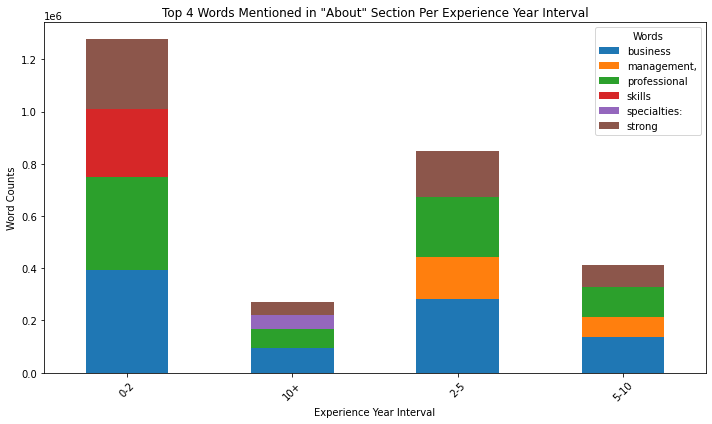

In [0]:
################################################ COMMON WORDS IN ABOUT
stop_words = set([
        "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "aren't", "as", "at", 
        "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", 
        "can't", "cannot", "could", "couldn't", "did", "didn't", "do", "does", "doesn't", "doing", "don't", "down", "during", 
        "each", "few", "for", "from", "further", 
        "had", "hadn't", "has", "hasn't", "have", "haven't", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", 
        "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "isn't", "it", "it's", "its", "itself", 
        "let's", "me", "more", "most", "mustn't", "my", "myself", 
        "no", "nor", "not", 
        "of", "off", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", 
        "same", "shan't", "she", "she'd", "she'll", "she's", "should", "shouldn't", "so", "some", "such", 
        "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", 
        "this", "those", "through", "to", "too", 
        "under", "until", "up", 
        "very", 
        "was", "wasn't", "we", "we'd", "we'll", "we're", "we've", "were", "weren't", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "won't", "would", "wouldn't", 
        "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves", "experience", "working", "years", "work", "new", "management", "customer", ".", ",", "!", "?", ";", ":", "'", "\"", "-", "—", "(", ")", "[", "]", "{", "}", "...", '``', "''", "`", "~", "@", "#", 
        "$", "%", "^", "&", "*", "_", "=", "+", "/", "\\", "|", "<", ">", "•", "°", "’", "“", "”", "can", "5" ])

def convert_duration_to_decimal(duration_str):
    try:
        if duration_str is None:
            return None
        parts = duration_str.split()
        years = 0
        months = 0
        if 'years' in duration_str or 'year' in duration_str:
            years = int(parts[0])
        if 'months' in duration_str or 'month' in duration_str:
            months_index = 2 if 'years' in duration_str or 'year' in duration_str else 0
            months = int(parts[months_index])
        return years + months / 12.0
    except ValueError:
        print(f"Cannot convert {duration_str} to decimal.")
        return None  

def categorize_exp_years(exp_year):
    if exp_year is None:
        return 'Unknown'  
    elif exp_year < 2:
        return '0-2'
    elif exp_year < 5:
        return '2-5'
    elif exp_year < 10:
        return '5-10'
    else:
        return '10+'

convert_duration_to_decimal_udf = udf(convert_duration_to_decimal, FloatType())
exploded_df = profiles.selectExpr("*", "explode(experience) as exp_flat")


exploded_df = exploded_df.withColumn("exp_years", convert_duration_to_decimal_udf("exp_flat.duration_short"))
words_df = exploded_df.select('exp_years', explode(split(lower(col('about')), '\s+')).alias('word'))
is_stop_word = udf(lambda word: word in stop_words, BooleanType())
filtered_words_df = words_df.filter(is_stop_word(words_df.word))
non_stop_words_df = words_df.filter(~is_stop_word(words_df.word))

exp_years_udf = udf(categorize_exp_years, StringType())

categorized_df = non_stop_words_df.withColumn("exp_years_category", exp_years_udf("exp_years"))

final_filtered_df = categorized_df.filter(col("exp_years_category") != "Unknown")


word_counts_df = final_filtered_df.groupBy("exp_years_category", "word").count()
windowSpec = Window.partitionBy('exp_years_category').orderBy(col('count').desc())
ranked_words_df = word_counts_df.withColumn('rank', rank().over(windowSpec))


top_words_df = ranked_words_df.filter(col('rank') <= 4)
top_words_pandas_df = top_words_df.toPandas()


pivot_df = top_words_pandas_df.pivot(index='exp_years_category', columns='word', values='count').fillna(0)

pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Top 4 Words Mentioned in "About" Section Per Experience Year Interval')
plt.xlabel('Experience Year Interval')
plt.ylabel('Word Counts')
plt.xticks(rotation=45)
plt.legend(title='Words')
plt.tight_layout()
plt.show()


**Now we will dig deeper into building features that will help us determine the seniority level of a person**

Our emphasis is directed towards the 'education' and 'experience' columns, as they serve as direct indicators of the individual's expertise ,which is closely tied to their seniority level.

We will start by calculating the number of education years :

In [0]:

from pyspark.sql import functions as F


total_years_of_education_df = profiles.select("id","name","education","current_company.company_id","experience")
#total_years_of_education_df=total_years_of_education_df.filter(F.col("company_id").isNotNull())


total_years_of_education_df = total_years_of_education_df.withColumn(
    "education",
    expr("filter(education, edu -> edu.start_year is not null and edu.end_year is not null)")
)

total_years_of_education_df = total_years_of_education_df.withColumn(
    "years_of_education",
    F.expr("TRANSFORM(education, e -> CAST(e.end_year AS INT) - CAST(e.start_year AS INT))")
)

total_years_of_education_df = total_years_of_education_df.withColumn("total_years_education", F.expr("AGGREGATE(years_of_education, 0, (acc, x) -> acc + x)"))
total_years_of_education_df=total_years_of_education_df.select("id" , "total_years_education")
total_years_of_education_df=total_years_of_education_df.orderBy(col("total_years_education").desc())

The distribution of years of Education :

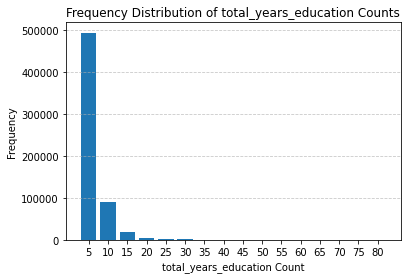

In [0]:
experience_counts = total_years_of_education_df.select("total_years_education")

experience_counts_list = [row['total_years_education'] for row in experience_counts.collect()]

frequency_distribution = [0] * 16  

for count in experience_counts_list:
    if count >= 5 and count <= 80:
        index = (count - 5) // 5 
        frequency_distribution[index] += 1  

x = list(range(5, 81, 5)) 
y = frequency_distribution

plt.bar(x, y, width=4)
plt.title('Frequency Distribution of total_years_education Counts')
plt.xlabel('total_years_education Count')
plt.ylabel('Frequency')
plt.xticks(x)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

We will move to calculating to number of Experiences :

In [0]:
df = df_profiles.withColumnRenamed("id", "user_id").withColumnRenamed("name", "user_name")

df_with_experience_count = df.withColumn("experience_count", size("experience"))

top_10_people = df_with_experience_count.orderBy(col("experience_count").desc()).limit(50)

Distribution of number of Experiences :

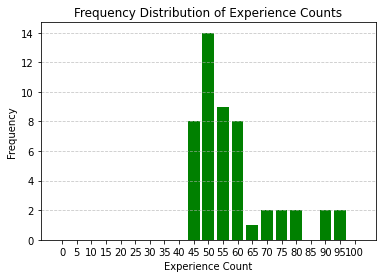

In [0]:
experience_counts = top_10_people.select("experience_count")

experience_counts_list = [row['experience_count'] for row in experience_counts.collect()]

frequency_distribution = [0] * 21  

for count in experience_counts_list:
    index = min(count // 5, 20)  
    frequency_distribution[index] += 1  

x = list(range(0, 101, 5))  
y = frequency_distribution

plt.bar(x, y, width=4 , color = 'green')
plt.title('Frequency Distribution of Experience Counts')
plt.xlabel('Experience Count')
plt.ylabel('Frequency')
plt.xticks(x)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Now after measuring the education and the experience level , we will look deeper into their hidden fields and values , which could guide us through determining the truthful industry of the person.

**Upon closer examination of the 'education' column, we notice that the 'field' subcolumn within the 'Education' column provides essential information about what subjects the individual studied during their academic journey**

<command-870587122525357>:17: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 

<Figure size 1440x2160 with 0 Axes>

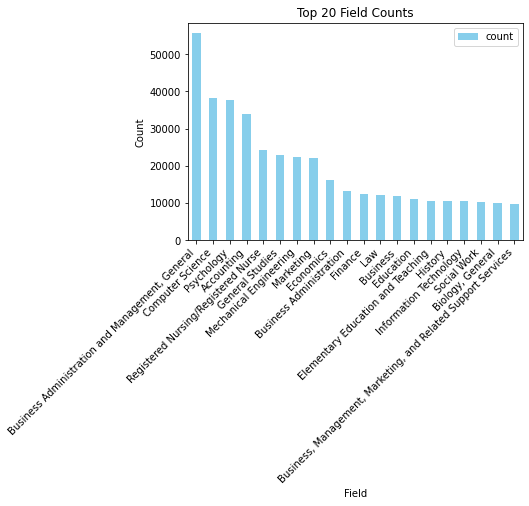

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import explode, col

df_exploded = df_profiles.select(explode(col("education")).alias("education"))
df_fields = df_exploded.select("education.field")
df_field_counts = df_fields.groupBy("field").count().orderBy(col("count").desc())
df_field_counts = df_field_counts.dropna()
pd_df = df_field_counts.limit(20).toPandas()

plt.figure(figsize=(20, 30))
pd_df.plot(kind='bar', x='field', y='count', color='skyblue')
plt.title('Top 20 Field Counts')
plt.xlabel('Field')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Now we will shift our focus into the hidden details inside column "Experience" :**

This specific column offers a narrative of individuals' experiences, providing details about their roles, responsibilities, accomplishments, and the industries they've been involved in. Therefore, our decision to prioritize the "Experience" column was rooted in its potential to provide solid information essential for building accurate predictive model.

In [0]:
############################## Exploration of Experience Column #############################################
from pyspark.sql.functions import explode
from pyspark.sql.functions import col, sum as spark_sum


df=profiles
exploded_df = df.withColumn("experience", explode("experience"))

selected_columns = [
    "id",
    "name",
    "experience.company",
    "experience.company_id",
    "experience.description",
    "experience.duration",
    "experience.end_date",
    "experience.location",
    "experience.start_date",
    "experience.subtitle",
    "experience.subtitleURL",
    "experience.title",
    "experience.url"
]

experience_df = exploded_df.select(selected_columns)

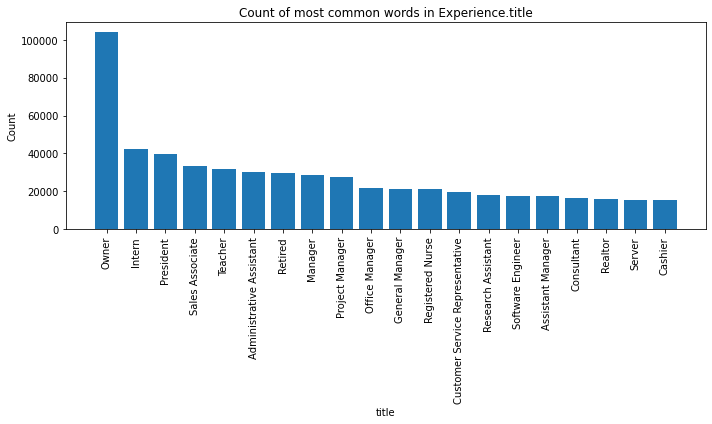

In [0]:
column_name = "title"
experience_df=experience_df.dropna(subset=["title"])
distinct_counts = experience_df.groupBy(column_name).count()

top_counts_Exp_title = distinct_counts.orderBy(col("count").desc())

top_counts_Exp_title=top_counts_Exp_title.limit(20)
top_counts_Exp_title_pd = top_counts_Exp_title.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(top_counts_Exp_title_pd["title"], top_counts_Exp_title_pd["count"])
plt.xlabel("title")
plt.ylabel("Count")
plt.title("Count of most common words in Experience.title")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**Overall we got compelling insights, the term "owner" emerged as particularly significant, alongside words like "Intern" or "President", so we can confidently take this pivotal feature into account when building the foundation for our predictive model**

Now we will examine the subColumn 'description' inside 'Experience':

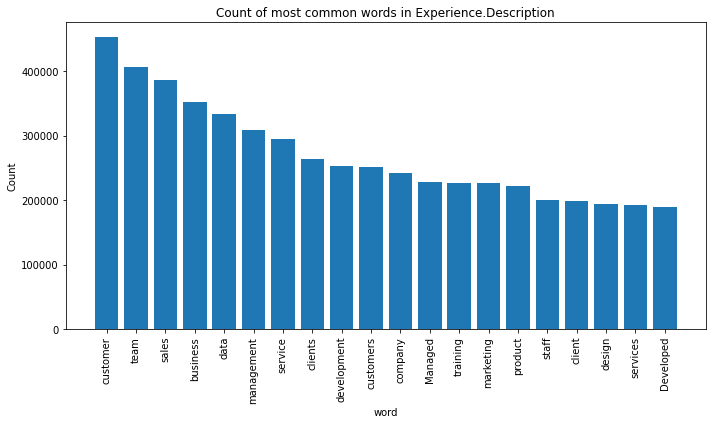

In [0]:
from pyspark.sql.functions import col, explode, split
from pyspark.ml.feature import StopWordsRemover

experience_description_df=experience_df.select("description")
experience_description_df=experience_description_df.dropna()
words_description_df = experience_description_df.select(explode(split(col("description"), "\\s+")).alias("word"))
default_stop_words = StopWordsRemover().getStopWords()

custom_stop_words = ["why", "the", "is", "I", "and", "in", "a", "of", "to", "with", "for", "on", "at", "it", "are","The","-","Your","A","How","What","You","Why","Is","&","My","Are","For","We","THE","•","less","Show","new","including","support","using","various","Responsible","well","daily","project","ensure","work","Worked","students"]

stop_words = default_stop_words + custom_stop_words
filtered_words_df = words_description_df.filter(~words_description_df.word.isin(stop_words))
word_description_counts = filtered_words_df.groupBy("word").count().orderBy("count", ascending=False)
word_description_counts=word_description_counts.limit(20)
word_description_counts = word_description_counts.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(word_description_counts["word"], word_description_counts["count"])
plt.xlabel("word")
plt.ylabel("Count")
plt.title("Count of most common words in Experience.Description")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

By identifying the most frequent words that appear in the experience descriptions, we aim to gain insights into the key topics or themes that individuals frequently mention in their experiences. 

This approach is valuable for feature selection in machine learning models because it allows us to capture the essence of individuals' experiences using a compact set of informative features. By incorporating these common words as features into our predictive model, we can enhance its ability to understand and classify individuals' fields or areas of expertise based on their experience descriptions. 

**Now we will look into the "cause" column from the "volunteer_experience"**

The reason for selecting such column stems from its inherent relevance in understanding individuals' interests and values. 

Volunteer experiences often reflect personal passions and commitments beyond professional pursuits. By examining the causes individuals choose to support through volunteering, we gain valuable insights into their values, interests, and potential career preferences.

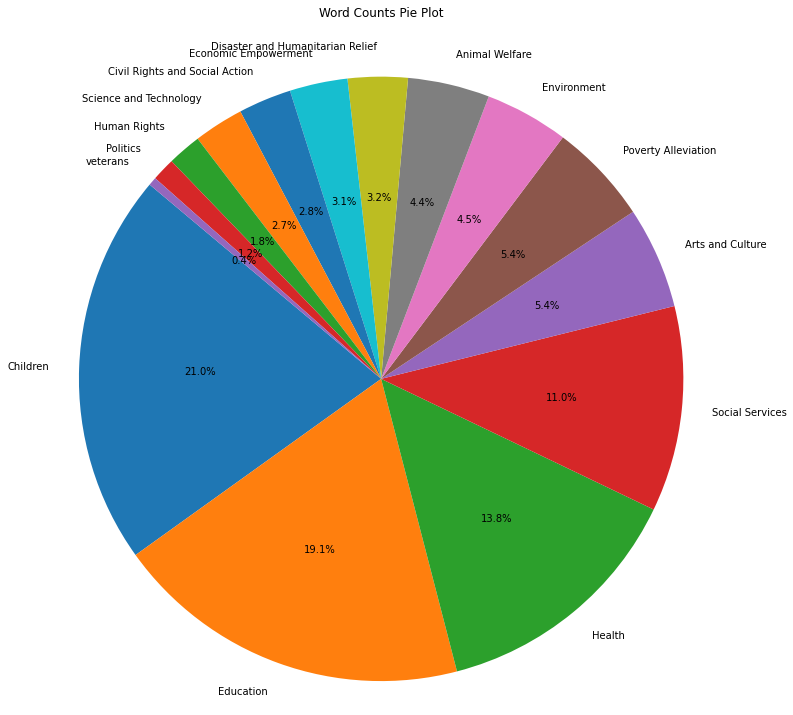

In [0]:
from pyspark.sql.functions import explode

import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import col

exploded_df3 = profiles.select("*", explode("volunteer_experience").alias("volunteer"))
cause_df = exploded_df3.select("volunteer.cause")
cause_df=cause_df.dropna()
distinct_causes = cause_df.distinct()
cause_counts = cause_df.groupBy("cause").count().orderBy("count", ascending=False)
words = cause_counts.select("cause").rdd.flatMap(lambda x: x).collect()
counts = cause_counts.select("count").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(12, 12))
plt.pie(counts, labels=words, autopct='%1.1f%%', startangle=140)
plt.title('Word Counts Pie Plot', y=1.05)  
plt.axis('equal')
plt.show()

The diverse range of causes represented in the dataset offers a wide understanding of individuals' interests and affiliations beyond their professional scope. By leveraging this information as features in our predictive model, we gain a deeper insight into the motivations and values that drive individuals' career choices and aspirations.

Overall, the "cause" column emerges as a pivotal feature in our predictive modeling efforts, enabling us to harness the vast information in the individuals' volunteer experiences to enhance the accuracy and efficacy of our field prediction algorithm.

**Finally, the "certifications" column contains valuable information regarding individuals' professional qualifications and credentials. By analyzing this column, we aim to extract insights into the types of certifications individuals hold, which can provide valuable clues about their fields of expertise :**

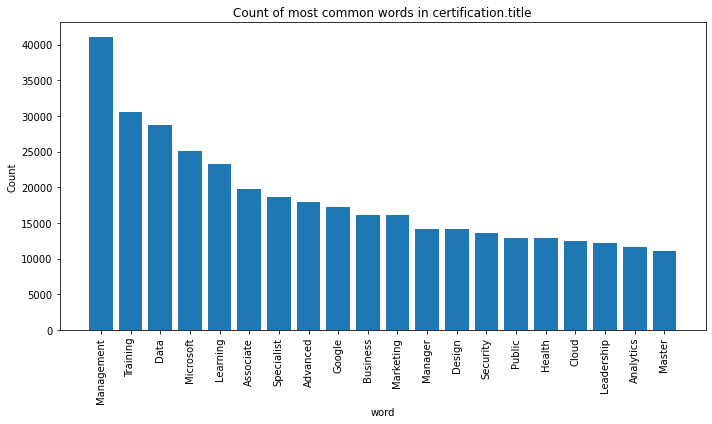

In [0]:
##################################################### Exploration of certifications Column ########################
from pyspark.sql.functions import col, explode, split
from pyspark.ml.feature import StopWordsRemover

exploded_df4 = profiles.select("*", explode("certifications").alias("certification"))
exploded_df4=exploded_df4.select("certification.title")
words_df = exploded_df4.select(explode(split(col("title"), "\\s+")).alias("word"))


default_stop_words = StopWordsRemover().getStopWords()

custom_stop_words = ["why", "the", "is", "I", "and", "in", "a", "of", "to", "with", "for", "on", "at", "it", "are","The","-","Your","A","How","What","You","Why","Is","&","My","Are","For","We","THE","Certified","Certification","Certificate","Project","Life","Six","Level","Foundations","First","Introduction","Support","Fundamentals","CompTIA","Professional","Essential","Basic","Belt","Sigma","Registered","Excel","License"]

stop_words = default_stop_words + custom_stop_words
filtered_words_df = words_df.filter(~words_df.word.isin(stop_words))
word_counts = filtered_words_df.groupBy("word").count().orderBy("count", ascending=False)
word_counts=word_counts.limit(20)
word_counts_pd = word_counts.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(word_counts_pd["word"], word_counts_pd["count"])
plt.xlabel("word")
plt.ylabel("Count")
plt.title("Count of most common words in certification.title")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Incorporating information about individuals' certifications as features enables us to capture crucial aspects of their professional profiles, aiding in the accurate prediction of both their fields and levels of expertise. Whether it's identifying specialized domains or recognizing advanced proficiency levels through certifications.

In summary, the "certifications" column serves as a pivotal feature in our predictive modeling efforts, providing essential insights into individuals' professional qualifications and expertise, thereby facilitating accurate predictions of their fields and levels of proficiency.

## AI Methodologies, First Part

#### Importing libraries


In [0]:
from pyspark.sql.functions import udf, col, lit  
from pyspark.sql.types import StringType 
import collections
from pyspark.ml.clustering import LDA
import sparknlp
from sparknlp.base import DocumentAssembler
from sparknlp.annotator import Tokenizer, Normalizer, LemmatizerModel
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, count, when, isnan, desc
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, first
from pyspark.ml.feature import Word2Vec
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType, ArrayType, StructType, StructField
import json
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, IDF, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql.functions import col, when, concat_ws
from pyspark.ml.feature import HashingTF, IDF, VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from sparknlp.base import DocumentAssembler
from sparknlp.annotator import Tokenizer, Normalizer, StopWordsCleaner
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.linalg import VectorUDT
from pyspark.sql.functions import array_contains, split
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col, when
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from sparknlp.pretrained import PretrainedPipeline
from pyspark.ml.feature import Word2Vec
import re
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.annotator import DistilBertEmbeddings
from sparknlp.base import DocumentAssembler
from sparknlp.annotator import Tokenizer, Normalizer, StopWordsCleaner
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT
import numpy as np
from pyspark.ml.feature import IndexToString, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

**Field Prediction Task:**

- *True Labels*: 'meta_industry' column from your dataset.

- *Objective*: Predict the industry field for each profile.

 - *Process*: After pre-processing, you'll use features derived from the profiles (like 'about', 'experience', etc.) to     build a predictive model that classifies each profile into the correct industry ('meta_industry').









**Level Prediction Task:**

- *True Labels*: 'seniority_level' column from your dataset.

- *Objective*: Predict the seniority level for each profile.

- *Process*: Using the insights from data analysis and the pre-processed dataset, this task will involve constructing another model. It will likely use similar features to the field prediction but target the 'seniority_level' to classify the career stage or level of seniority for each profile.

### Feature engineering and selection methods

 In this part, we first implemented methods that can help us extract the data we found interesting and relevant for our prediction section using the data analysis part, and integrating the data as a new column in the profiles dataframe.
 - NOTE: we make sure that we don't lose any of the features in the data , for example in experience.title rows for each profile there can be multiple experiences, we include them all with a "space" divider.

####Opening nested columns in profiles dataframe using dynamic arguments method

In [0]:

def extract_column_from_nested(nested_column, column_name):
    if not nested_column or nested_column == [] or nested_column == {}:
        return None
    else:
        return ' '.join([column[column_name] for column in nested_column if column_name in column and column[column_name] is not None])
        


extract_column_from_nested_udf = udf(extract_column_from_nested, StringType())

def preprocessing_pre_df(df, **kwargs):
    for nested_col_detail, extraction_details in kwargs.items():
        nested_col, inner_col_name, new_col_name = extraction_details
        df = df.withColumn(new_col_name, extract_column_from_nested_udf(col(nested_col), lit(inner_col_name)))
    return df



Adding the dataframe from the analysis part, such that we don't have null "postion" and with "seniority_level" for each profile.

In [0]:
df_prof = rows_with_position

 Based on the data analysis part above, these are the features assumingly relevant for the project prediction task.

In [0]:
df_transformed_prof = preprocessing_pre_df(df_prof,
    detail1=('education', 'field', 'education_field'),
    detail2=('certifications', 'title', 'certifications_title'),
    detail3=('experience', 'title', 'experience_title'),
    detail4=('volunteer_experience', 'cause', 'volunteer_experience_cause'),
    detail5=('experience', 'description', 'experience_description'),
    detail6=('experience', 'company_id', 'experience_company_id')
)
df_transformed_prof = df_transformed_prof.withColumn("current_company_title", col("current_company.title"))
df_transformed_prof = df_transformed_prof.withColumn("company_id", col("current_company.company_id"))
df_transformed_prof = df_transformed_prof.withColumn("company_industry", col("current_company.industry"))

 Comapanies dataframe adjusting : Filter irrelevant columns in companies dataframe for more training data and drop rows with no "sphere"

 We are interested in two columns in companies dataframe: "sphere" and "meta_industry" , there purpose is to extract true labels for field prediction

In [0]:
columns_to_drop = ['about', 'affiliated', 'company_id', 'company_size', 'country_code', 'crunchbase_url', 'employees', 'employees_in_linkedin', 'followers', 'formatted_locations', 'founded', 'funding', 'headquarters', 'image', 'industries','investors', 'locations', 'logo', 'name', 'organization_type', 'similar', 'slogan', 'stock_info', 'timestamp', 'type', 'updates', 'url', 'website']
filtered_df_comp = df_companies.drop(*columns_to_drop)
filtered_df_comp = filtered_df_comp.filter(col("sphere").isNotNull())

 Map each "industry" to its corresponding "meta_industry"

In [0]:

meta_industries_12 = {
'Furniture and Home Furnishings Manufacturing': 'Manufacturing',
'Investment Banking': 'Financial and Investment',
'Architecture and Planning': 'Services',
'Wholesale': 'Services',
'Travel Arrangements': 'Services',
'Ranching': 'Miscellaneous',
'Hospitals and Health Care': 'Healthcare and Medical',
'Book and Periodical Publishing': 'Services',
'Printing Services': 'Services',
'Professional Training and Coaching': 'Services',
'Computers and Electronics Manufacturing': 'Manufacturing',
'Shipbuilding': 'Manufacturing',
'Public Policy Offices': 'Government and Public Policy',
'Software Development': 'Technology',
'Outsourcing and Offshoring Consulting': 'Services',
'Retail Groceries': 'Retail and Consumer Goods',
'Education Administration Programs': 'Education and Training',
'Plastics Manufacturing': 'Manufacturing',
'Renewable Energy Semiconductor Manufacturing': 'Manufacturing',
'Computer Networking Products': 'Technology',
'Events Services': 'Services',
'Information Services': 'Services',
'Food and Beverage Services': 'Services',
'Semiconductor Manufacturing': 'Manufacturing',
'Business Consulting and Services': 'Services',
'Insurance': 'Services',
'Financial Services': 'Services',
'Wireless Services': 'Services',
'Computer Hardware Manufacturing': 'Technology',
'Public Safety': 'Services',
'Maritime Transportation': 'Transportation and Logistics',
'Tobacco Manufacturing': 'Manufacturing',
'Writing and Editing': 'Services',
'Veterinary Services': 'Services',
'Staffing and Recruiting': 'Services',
'Accounting': 'Services',
'International Affairs': 'Government and Public Policy',
'Spectator Sports': 'Miscellaneous',
'Glass, Ceramics and Concrete Manufacturing': 'Manufacturing',
'Chemical Manufacturing': 'Manufacturing',
'Mining': 'Miscellaneous',
'E-Learning Providers': 'Technology',
'Security and Investigations': 'Services',
'Translation and Localization': 'Services',
'Automation Machinery Manufacturing': 'Technology',
'Computer and Network Security': 'Technology',
'Political Organizations': 'Government and Public Policy',
'Environmental Services': 'Government and Public Policy',
'Oil and Gas': 'Miscellaneous',
'Real Estate': 'Real Estate and Construction',
'Think Tanks': 'Government and Public Policy',
'Executive Offices': 'Miscellaneous',
'Law Practice': 'Services',
'Nanotechnology Research': 'Miscellaneous',
'International Trade and Development': 'Government and Public Policy',
'Personal Care Product Manufacturing': 'Manufacturing',
'Philanthropic Fundraising Services': 'Services',
'Entertainment Providers': 'Media and Entertainment',
'Market Research': 'Media and Entertainment',
'Movies, Videos, and Sound': 'Media and Entertainment',
'Sporting Goods Manufacturing': 'Manufacturing',
'Graphic Design': 'Services',
'Technology, Information and Internet': 'Technology',
'IT Services and IT Consulting': 'Technology',
'Retail Office Equipment': 'Retail and Consumer Goods',
'Wholesale Import and Export': 'Services',
'Capital Markets': 'Financial and Investment',
'Law Enforcement': 'Services',
'Freight and Package Transportation': 'Transportation and Logistics',
'Industrial Machinery Manufacturing': 'Manufacturing',
'Non-profit Organizations': 'Miscellaneous',
'Retail Art Supplies': 'Retail and Consumer Goods',
'Animation and Post-production': 'Media and Entertainment',
'Transportation, Logistics, Supply Chain and Storage': 'Transportation and Logistics',
'Aviation and Aerospace Component Manufacturing': 'Transportation and Logistics',
'Fundraising': 'Financial and Investment',
'Railroad Equipment Manufacturing': 'Transportation and Logistics',
'Construction': 'Real Estate and Construction',
'Investment Management': 'Financial and Investment',
'Utilities': 'Miscellaneous',
'Retail Luxury Goods and Jewelry': 'Retail and Consumer Goods',
'Warehousing and Storage': 'Transportation and Logistics',
'Media Production': 'Media and Entertainment',
'Gambling Facilities and Casinos': 'Media and Entertainment',
'Defense and Space Manufacturing': 'Manufacturing',
'Facilities Services': 'Services',
'Government Relations Services': 'Government and Public Policy',
'Advertising Services': 'Media and Entertainment',
'Paper and Forest Product Manufacturing': 'Manufacturing',
'Packaging and Containers Manufacturing': 'Manufacturing',
'Telecommunications': 'Technology',
'Medical Equipment Manufacturing': 'Healthcare and Medical',
'Beverage Manufacturing': 'Manufacturing',
'Restaurants': 'Retail and Consumer Goods',
'Leasing Non-residential Real Estate': 'Real Estate and Construction',
'Newspaper Publishing': 'Media and Entertainment',
'Armed Forces': 'Miscellaneous',
'Appliances, Electrical, and Electronics Manufacturing': 'Manufacturing',
'Hospitality': 'Services',
'Pharmaceutical Manufacturing': 'Healthcare and Medical',
'Research Services': 'Services',
'Retail Apparel and Fashion': 'Retail and Consumer Goods',
'Photography': 'Media and Entertainment',
'Wellness and Fitness Services': 'Services',
'Truck Transportation': 'Transportation and Logistics',
'Consumer Services': 'Services',
'Wholesale Building Materials': 'Services',
'Human Resources Services': 'Services',
'Airlines and Aviation': 'Transportation and Logistics',
'Machinery Manufacturing': 'Manufacturing',
'Individual and Family Services': 'Services',
'Motor Vehicle Manufacturing': 'Manufacturing',
'Performing Arts': 'Media and Entertainment',
'Museums, Historical Sites, and Zoos': 'Media and Entertainment',
'Broadcast Media Production and Distribution': 'Media and Entertainment',
'Banking': 'Financial and Investment',
'Recreational Facilities': 'Miscellaneous',
'Government Administration': 'Government and Public Policy',
'Public Relations and Communications Services': 'Media and Entertainment',
'Fisheries': 'Miscellaneous',
'Medical Practices': 'Healthcare and Medical',
'Religious Institutions': 'Miscellaneous',
'Online Audio and Video Media': 'Media and Entertainment',
'Artists and Writers': 'Miscellaneous',
'Biotechnology Research': 'Healthcare and Medical',
'Legal Services': 'Services',
'Retail': 'Retail and Consumer Goods',
'Civil Engineering': 'Services',
'Libraries': 'Miscellaneous',
'Alternative Dispute Resolution': 'Miscellaneous',
'Manufacturing': 'Miscellaneous',
'Design Services': 'Services',
'Dairy Product Manufacturing': 'Manufacturing',
'Higher Education': 'Education and Training',
'Civic and Social Organizations': 'Miscellaneous',
'Textile Manufacturing': 'Manufacturing',
'Venture Capital and Private Equity Principals': 'Financial and Investment',
'Mental Health Care': 'Healthcare and Medical',
'Musicians': 'Media and Entertainment',
'Farming': 'Miscellaneous',
'Computer Games': 'Media and Entertainment',
'Strategic Management Services': 'Services',
'Food and Beverage Manufacturing': 'Manufacturing',
'Primary and Secondary Education': 'Education and Training',
'Alternative Medicine': 'Healthcare and Medical',
'Legislative Offices': 'Services',
'Administration of Justice': 'Services',
'Mobile Gaming Apps': 'Media and Entertainment'
}
meta_industry = udf( lambda x: meta_industries_12[x] )
filtered_df_comp = filtered_df_comp.withColumn('meta_industry', meta_industry(col('sphere')))


Initially, we ensure that profiles (df_transformed_prof) have either a non-null 'company_id' or 'company_industry' to be considered for the prediction task. Similarly, we filter companies (filtered_df_comp) to include only those with a non-null 'id' or 'sphere'.

The 'id' column in filtered_df_prof is renamed to 'profile_id' to prevent ambiguity post-join.

In [0]:
filtered_df_prof = df_transformed_prof.filter(col("company_id").isNotNull() | col("company_industry").isNotNull())
filtered_df_comp = filtered_df_comp.filter(col("id").isNotNull() | col("sphere").isNotNull())


Optional: **Fine Tuning**
##### We wanted to sample a smaller data frame with the same distribution as the orignal dataframe to solve run time problem and to find the true labels of the data, in addition to find the best parameters for our predection model. 

##### **We used it for "sphere" column in order to sample a dataframe that don't need alot of run time for diffrent operations we used in this section of the project, like trying KMeans, LDA and other unsupervised learning algorithims for producing training data**


In [0]:
# Get the fractions for each category to maintain the distribution
fractions = filtered_df_comp.select("sphere").distinct().rdd.flatMap(lambda x: x).collect()
fractions = {category: 0.1 for category in fractions}  # 10% of each category
sampled_df = filtered_df_comp.sampleBy("sphere", fractions, seed=42)
print("Original DataFrame row count:", filtered_df_comp.count())
print("Sampled DataFrame row count:", sampled_df.count())

**Join Operation:**
- A left join is performed between filtered_df_prof and filtered_df_comp where the 'company_id' of a profile is matched with the 'id' of a company, or the 'company_industry' of a profile is matched with the 'sphere' of a company.
- This join is intended to enrich the profiles with relevant company information that might be indicative of the 'meta_industry'.

In [0]:

filtered_df_prof = filtered_df_prof.withColumnRenamed("id", "profile_id")
joined_df = filtered_df_prof.join(filtered_df_comp, (filtered_df_prof.company_id == filtered_df_comp.id) | 
                                  (filtered_df_prof.company_industry == filtered_df_comp.sphere), "left")

 DataFrame row count: 10390450


In [0]:
joined_df.show(n=25, truncate=100, vertical=True)

-RECORD 0--------------------------------------------------------------------------------------------------------------------------
 about                      | null                                                                                                 
 avatar                     | https://media.licdn.com/dms/image/D5603AQFAjL9sO31R9g/profile-displayphoto-shrink_800_800/0/16837... 
 certifications             | []                                                                                                   
 city                       | Dubuque, Iowa, United States                                                                         
 country_code               | US                                                                                                   
 current_company            | {flexsteel-industries-inc, Flexsteel Industries Inc., https://lb.linkedin.com/company/flexsteel-i... 
 current_company:company_id | flexsteel-industries-inc                      

**Selection and Filtration:**

- Selecting relevant columns for the prediction task and ensure that mandatory fields are not null. Mandatory fields include personal profile information and job-related attributes that will be used as features for prediction, alongside the 'seniority_level' and 'meta_industry' which are the true labels for training.




In [0]:
final_df = joined_df.select(
    "profile_id", "certifications_title", "current_company_title", "education_field",
    "experience_title", "experience_description", "position", "volunteer_experience_cause", "about", "company_industry",
    "seniority_level", "meta_industry"
    ).filter(
    (col("about").isNotNull() |
    col("certifications_title").isNotNull() |
    col("current_company_title").isNotNull() |
    col("education_field").isNotNull() |
    col("experience_title").isNotNull() |
    col("experience_description").isNotNull() |
    col("position").isNotNull() |
    col("volunteer_experience_cause").isNotNull()) & 
    # Labels we want to train on
    (col("seniority_level").isNotNull()) &
    (col("meta_industry").isNotNull())
    )

# print(" DataFrame row count:", final_df.count())

**Duplicate Removal:**

- From the resulting joined dataframe, remove duplicates based on a combination of profile attributes to ensure uniqueness in the dataset.


In [0]:
joined_df_final = final_df.dropDuplicates(["certifications_title", "current_company_title", "education_field",
    "experience_title", "experience_description", "position", "volunteer_experience_cause", "about", "company_industry",
    "seniority_level"])


The final processed dataset joined_df_final now serves as the input for developing a model to predict the 'meta_industry' for each professional profile, using 'seniority_level' and profile attributes as features for this supervised learning task.

We compiled a single, coherent text representation of each user by combining different profile attributes such as professional experience, certifications, and educational background. This composite text data will then serve as input for a machine learning model tasked with the first main prediction: identifying the industry category (meta_industry) relevant to each profile.


In [0]:

combined_text = concat_ws(" ",
when(col("about").isNull(), "").otherwise(col("about")),
when(col("certifications_title").isNull(), "").otherwise(col("certifications_title")),
when(col("current_company_title").isNull(), "").otherwise(col("current_company_title")),
when(col("education_field").isNull(), "").otherwise(col("education_field")),
when(col("experience_title").isNull(), "").otherwise(col("experience_title")),
when(col("position").isNull(), "").otherwise(col("position")),
when(col("volunteer_experience_cause").isNull(), "").otherwise(col("volunteer_experience_cause"))
).alias("combined_text")
combined_df = joined_df_final.withColumn("combined_text", combined_text)

In this part, a natural language processing pipeline is constructed to prepare text data for our predictive modeling. Initially, the Document Assembler sets up the raw data, converting the 'combined_text' column into a structured format. Following this, the Tokenizer breaks down the text into individual words or tokens. These tokens are then standardized by the Normalizer, which, among other things, converts them to lowercase. The StopWordsCleaner further refines the token list by removing common words that typically don't carry unique information.

The reason behind the processing lies in the application of a pre-trained BERT model through the Bert Embeddings stage, which transforms the tokens into rich, contextual embeddings. These embeddings capture the nuanced meanings of words in context, which is crucial for understanding the text's field of relevance among our "meta_industry" catigories

Finally, the Sentence Embeddings stage consolidates these detailed embeddings into a single vector representation for each document, averaging out the embeddings from individual tokens. This condensed vector effectively captures the essence of the entire text block, making it suitable for feeding into our machine learning model.

The purpose of this pipeline is to enable the extraction of our selected features from text data, which are essential for accurate predictions in the project's field prediction task. By converting raw text into a structured, machine-understandable format with deep contextual awareness so we can feed to the NLP pipeline

In [0]:

document_assembler = DocumentAssembler() \
    .setInputCol("combined_text") \
    .setOutputCol("document")

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normalized") \
    .setLowercase(True)

stopwords_cleaner = StopWordsCleaner() \
    .setInputCols(["normalized"]) \
    .setOutputCol("clean_tokens") \
    .setCaseSensitive(False)


bert_embeddings = BertEmbeddings.pretrained("small_bert_L2_128", "en") \
    .setInputCols(["document", "clean_tokens"]) \
    .setOutputCol("embeddings") \
    .setCaseSensitive(False)


embeddings_sentence = SentenceEmbeddings() \
    .setInputCols(["document", "embeddings"]) \
    .setOutputCol("sentence_embeddings") \
    .setPoolingStrategy("AVERAGE")



nlp_pipeline = Pipeline(stages=[
    document_assembler, 
    tokenizer, 
    normalizer,
    stopwords_cleaner,
    bert_embeddings,
    embeddings_sentence
])

bert_field_model = nlp_pipeline.fit(combined_df)
result = bert_field_model.transform(combined_df)

small_bert_L2_128 download started this may take some time.
Approximate size to download 16.1 MB
[OK!]


The embeddings_to_vector function transforms embeddings into dense vectors, preparing them for LogisticRegression model by either flattening nested arrays or filling missing embeddings with zeros. This processed data is then applied to the DataFrame, enabling the model to effectively learn from the text embeddings.

In [0]:

def embeddings_to_vector(embeddings):
    default_vector_size = 128
    if embeddings == [[]] or not embeddings:
        return Vectors.dense([0.0] * default_vector_size)
    # Check if embeddings are nested and flatten if necessary
    if embeddings and isinstance(embeddings[0], list):
        flat_embeddings = [item for sublist in embeddings for item in sublist]
    else:
        flat_embeddings = embeddings
    return Vectors.dense(flat_embeddings)

embeddings_to_vector_udf = udf(embeddings_to_vector, VectorUDT())

result_with_vectors = result.withColumn("features", embeddings_to_vector_udf(col("sentence_embeddings.embeddings")))

We sat up a pipeline for a logistic regression model to classify texts into meta_industry categories, utilizing a sequence of data preprocessing, model training, and evaluation stages. It then assesses the model's accuracy on a split test set, providing a concise measure of its predictive performance.

In [0]:


label_indexer = StringIndexer(inputCol="meta_industry", outputCol="label").fit(result)
label_converter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                                labels=label_indexer.labels)


lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=20, regParam=0.3)

pipeline = Pipeline(stages=[label_indexer, lr, label_converter])


(training_data, test_data) = result_with_vectors.randomSplit([0.8, 0.2])

model = pipeline.fit(training_data)

predictions = model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)


Accuracy: 0.42784025860327296


In [0]:
df_with_predicted_field=model.transform(result_with_vectors)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(df_with_predicted_field)
print("Accuracy:", accuracy)

Accuracy: 0.4303531786074672


Now we need to use "df_with_predicted_field" dataframe for "level" label prediction

In [0]:
columns_to_drop = ["combined_text", "document", "token", "normalized", 'clean_tokens', "embeddings", 'sentence_embeddings', 'features', 'label', 'rawPrediction', 'probability', 'prediction']
df_with_predicted_field = df_with_predicted_field.drop(*columns_to_drop)
df_with_predicted_field = df_with_predicted_field.filter(col("seniority_level").isNotNull())
print("fields DataFrame row count:", df_with_predicted_field.count())

fields DataFrame row count: 74325


 In this part, predicting the 'level' for each profile. This involves leveraging the insights and data transformations from the previous field prediction task to  classify profiles based on their "experience_title" and "position" columns combined us one column. 

To predict the "seniority_level" for each profile, features were curated by concatenating non-null "experience_title" and "position" into a single text column, named "combined_text_level". This approach harnesses detailed professional experience and current role information, aiming to enhance the prediction model's accuracy for selecting few columns only for determining the seniority level within the dataset.

In [0]:

combined_text = concat_ws(" ",
when(col("experience_title").isNull(), "").otherwise(col("experience_title")),
when(col("position").isNull(), "").otherwise(col("position"))
).alias("combined_text_level")
df_with_predicted_field = df_with_predicted_field.withColumn("combined_text_level", combined_text)
print("Combined DataFrame row count:", df_with_predicted_field.count())


Combined DataFrame row count: 74325


Here is the same pre-proccess pipeline for predicting "field" , just for diffrent text feature: "combined_text_level"

In [0]:

document_assembler = DocumentAssembler() \
    .setInputCol("combined_text_level") \
    .setOutputCol("document")

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normalized") \
    .setLowercase(True)

stopwords_cleaner = StopWordsCleaner() \
    .setInputCols(["normalized"]) \
    .setOutputCol("clean_tokens") \
    .setCaseSensitive(False)


bert_embeddings = BertEmbeddings.pretrained("small_bert_L2_128", "en") \
    .setInputCols(["document", "clean_tokens"]) \
    .setOutputCol("embeddings") \
    .setCaseSensitive(False)


# Convert custom embeddings into vectors
embeddings_sentence = SentenceEmbeddings() \
    .setInputCols(["document", "embeddings"]) \
    .setOutputCol("sentence_embeddings") \
    .setPoolingStrategy("AVERAGE")



nlp_pipeline = Pipeline(stages=[
    document_assembler, 
    tokenizer, 
    normalizer,
    stopwords_cleaner,
    bert_embeddings,
    embeddings_sentence
])

# Apply the pipeline to the DataFrame
bert_level_model = nlp_pipeline.fit(df_with_predicted_field)
result = bert_level_model.transform(df_with_predicted_field)

small_bert_L2_128 download started this may take some time.
Approximate size to download 16.1 MB
[OK!]


In [0]:
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT
import numpy as np

def embeddings_to_vector(embeddings):
    default_vector_size = 128
    if embeddings == [[]] or not embeddings:
        return Vectors.dense([0.0] * default_vector_size)
    # Check if embeddings are nested and flatten if necessary
    if embeddings and isinstance(embeddings[0], list):
        flat_embeddings = [item for sublist in embeddings for item in sublist]
    else:
        flat_embeddings = embeddings
    return Vectors.dense(flat_embeddings)

embeddings_to_vector_udf = udf(embeddings_to_vector, VectorUDT())

result_with_vectors_levels = result.withColumn("features", embeddings_to_vector_udf(col("sentence_embeddings.embeddings")))

To forecast the "seniority_level" across profiles, we utilize a machine learning pipeline that involves: encoding the "seniority_level" column into numerical labels, applying Logistic Regression for prediction based on dense vector features, and converting numeric predictions back to their original string representation. This process enables the creation of a predictive model, aimed at determining the seniority level of professional profiles.

In [0]:
from pyspark.ml.feature import IndexToString, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

label_indexer = StringIndexer(inputCol="seniority_level", outputCol="label").fit(result_with_vectors_levels)


lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=20, regParam=0.3)

label_converter = IndexToString(inputCol="prediction", outputCol="predictedLabel_level",
                                labels=label_indexer.labels)

pipeline = Pipeline(stages=[label_indexer, lr, label_converter])


(training_data, test_data) = result_with_vectors_levels.randomSplit([0.8, 0.2])

model = pipeline.fit(training_data)

predictions = model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)


Accuracy: 0.6907265130071438


## AI Methodologies, Second Part

**Upon completing the initial phase of our AI Solution, which involves predicting the individual's field/industry and their seniority level, we can proceed to develop Optimal Paths using unsupervised learning methods and algorithms:**

**Now our plan is to use an unsupervised learning algorithm by building a multidimensional space as follows :**
1) we will transform each job name into a vector using Word2Vec (dimension 100)
2) we will convert the person's position into a vector (with Word2Vec) and then match them with relevant job opportunities using the cosine similarity.
3) For each profile, we'll utilize the predicted field and seniority level alongside the individual's current position to identify relevant job opportunities.
4) when building the optimal path we will take into account the job's rating and salary
5) By integrating the job's rating, salary, and the similarity metric derived from step 2, we anticipate achieving great outcomes in crafting the optimal career paths.

In [0]:
input = predictions

In [0]:
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.linalg import Vectors

vecAssembler = VectorAssembler(inputCols=["Rating"], outputCol="feature_rating")
final_scraped = vecAssembler.transform(final_scraped)
scaler = MinMaxScaler(inputCol="feature_rating", outputCol="rating_normalized")
scaler_model = scaler.fit(final_scraped)
final_scraped = scaler_model.transform(final_scraped)

vecAssembler = VectorAssembler(inputCols=["Job Salary"], outputCol="feature_salary")
final_scraped = vecAssembler.transform(final_scraped)
scaler = MinMaxScaler(inputCol="feature_salary", outputCol="job_salary_normalized")
scaler_model = scaler.fit(final_scraped)
final_scraped = scaler_model.transform(final_scraped)

extract_value_udf = udf(lambda vector: float(vector[0]), FloatType())
final_scraped = final_scraped.withColumn("rating_normalized", extract_value_udf("rating_normalized"))
final_scraped = final_scraped.withColumn("job_salary_normalized", extract_value_udf("job_salary_normalized"))

**We'll begin by using our scraped data containing job listings, organizing them into industry-specific groups ordered by seniority level for convenient access**

Each Job Name is represented with a vector using Word2Vec (dimension 100)

Each job item is a list of 4 elements : ["Job Name", "job_vector" , 'rating_normalized' , 'job_salary_normalized']

Each industry has 6 elements , where each element is a list of all the jobs items in this level by industry

In [0]:
from pyspark.ml.feature import Word2Vec, Word2VecModel
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer
from pyspark.sql.functions import collect_list

tokenizer = Tokenizer(inputCol="Job Name", outputCol="words")
tokenized_df = tokenizer.transform(final_scraped)
word2Vec = Word2Vec(vectorSize=100, minCount=0, inputCol="words", outputCol="wordVectors")
word2Vec_model = word2Vec.fit(tokenized_df)
word_vectors_df = word2Vec_model.transform(tokenized_df)

df_with_struct = word_vectors_df.withColumn("jobVectorPair", struct("Job Name", "wordVectors" , 'rating_normalized' , 'job_salary_normalized'))
grouped_df_with_pairs = df_with_struct.groupby("Industry", "level").agg(collect_list("jobVectorPair").alias("jobVectorPairsList"))

def ordering(level):
    if level == "Internship" :
        num = 0
    if level == "Entry Level" :
        num = 1
    if level == "Mid Senior" :
        num = 2
    if level == "Director" :
        num = 3
    if level == "Executive" :
        num = 4
    if level == "Retired" :
        num = 5

    return num
    
leveling = F.udf(ordering , IntegerType())

grouped_df_with_pairs = grouped_df_with_pairs.withColumn("level_order", leveling("level"))
grouped_df_with_pairs = grouped_df_with_pairs.orderBy("Industry" ,"level_order")

grouped_industry = grouped_df_with_pairs.groupby("Industry").agg(collect_list("jobVectorPairsList").alias("industry_vectors"))

jobs_df = grouped_industry.select('Industry' ,'industry_vectors')
jobs_df.select("industry_vectors").show(truncate = 70)

+----------------------------------------------------------------------+
|                                                      industry_vectors|
+----------------------------------------------------------------------+
|[[{Treasury 2024 Summer Finance Fellowship- Massachusetts School Bu...|
|[[{School Psychologist, Summer Assessment Team (Summer 2024), Distr...|
|[[{Summer Teller, [-0.05841318122111261,0.053256776416674256,0.0157...|
|[[{Seasonal Sales Associate (SUMMER 2024)- Allen Americans Professi...|
|[[{Civil Engineering Co-op - Transportation, [-0.025615197187289596...|
|[[{Substitute School Nurse RN - Summer Program, [-0.052845864523468...|
|[[{Seasonal Laborer (Summer Job - DPW), [-0.026862728060223162,0.00...|
|[[{Cubs Baseball Summer Camps Camp & Safety Coordinator: 2023-3127,...|
|[[{Fall 2024 Construction Project Management Co-op, [-0.04291762222...|
|[[{Media Paraprofessional, Summer Only, [-0.04180739040020853,0.036...|
|[[{Co-op Process Engineer, [-0.021824822217846908,

Using Word2Vec to build vector for each profile's position

In [0]:
input = input.fillna("")

tokenizer = Tokenizer(inputCol="position", outputCol="words")
tokenized_df = tokenizer.transform(input)
word2Vec = Word2Vec(vectorSize=100, minCount=0, inputCol="words", outputCol="positionVector")
word2Vec_model = word2Vec.fit(tokenized_df)
input_df = word2Vec_model.transform(tokenized_df)

input_df = input_df.select('profile_id' ,'position', 'positionVector' , 'predictedLabel' , 'predictedLabel_level')

In [0]:
joined_df = input_df.join(jobs_df, on=input_df['predictedLabel'] == jobs_df['Industry'], how='inner')
joined_df = joined_df.select('profile_id' ,"predictedLabel_level" ,'positionVector', 'industry_vectors' , "predictedLabel")
df_with_random = joined_df.withColumn("random", F.rand())
shuffled_df = df_with_random.orderBy("random")
joined_df = shuffled_df.drop("random")


**Finding the path for each profile:**

In [0]:
from pyspark.ml.linalg import Vector

def balista(level , position_vector, industry_vectors):

    if level == "Internship" : level_num = 0
    if level == "Entry Level" : level_num = 1
    if level == "Mid Senior" : level_num = 2
    if level == "Director" : level_num = 3
    if level == "Executive" : level_num = 4
    if level == "Retired" : level_num = 5

    optimal_path = []
    for i in range(level_num , len(industry_vectors)):
        def cosine_similarity(vec1, vec2):
            dot_product = float(vec1.dot(vec2))
            norm_vec1 = float(vec1.norm(2))
            norm_vec2 = float(vec2.norm(2))
            if norm_vec1 == 0 or norm_vec2 == 0: return 0
            similarity = dot_product / (norm_vec1 * norm_vec2)
            return similarity

        max_similarity = float('-inf')
        most_similar_job_name = None

        for job_pair in industry_vectors[i]:
            job_name = job_pair["Job Name"]
            job_vector = job_pair["wordVectors"]
            job_rating = job_pair["rating_normalized"]
            job_salary = job_pair["job_salary_normalized"]

            similarity = cosine_similarity(position_vector, job_vector)
            result = (0.9 * similarity)

            if result > max_similarity:
                max_similarity = result
                most_similar_job_name = job_name
        optimal_path.append(most_similar_job_name)

    return optimal_path
    
bali = F.udf(balista , ArrayType(StringType()))

joined_df = joined_df.withColumn("result", bali("predictedLabel_level" , "positionVector" , 'industry_vectors'))


In [0]:
joined_df = joined_df.select('profile_id', "predictedLabel_level" , "predictedLabel" ,"result")
joined_df.show()

+--------------------+--------------------+--------------------+--------------------+
|          profile_id|predictedLabel_level|      predictedLabel|              result|
+--------------------+--------------------+--------------------+--------------------+
|megan-stearns-7bb...|          Mid Senior|            Services|[Senior Administr...|
|     kaile-applebaum|          Mid Senior|Healthcare and Me...|[VHO - Clinical C...|
| eric-smith-5a89443a|          Mid Senior|          Technology|[Workday HCM Payr...|
|jamie-quinn-b8475074|            Director|            Services|[ADON - Assistant...|
|jessica-kwon-aa4b5b4|          Mid Senior|Healthcare and Me...|[VHO - Clinical C...|
|      vanitaaggarwal|            Director|            Services|[DIRECTOR OF PUBL...|
|         kevinford43|          Mid Senior|            Services|[Quality Engineer...|
|ashley-harper-57b...|          Mid Senior|            Services|[Attendant II - H...|
|john-campbell-488...|          Mid Senior|Education a

##Evaluation and Results

**Quick Recap:**

Our journey began when we started scraping job listings from Glassdoor and laying the foundation for predicting individual career trajectories.

In order to find the best features for our prediction model , we employed various analysis techniques informing our selection of predictive model features.

We built various Machine Learning algorithms to develop our prediction model.

Our ultimate aim was Empowering individuals with tailor-made career guidance, by building them optimal path specifically suited for them.

**Now we will examine the results :**

**COOOOOOOOOOOOOOOOODDDDDDDEEEEEEEEEEEE !!!!!!!!!!!!!!!!!!!!!!!!!!!!**

Our final algorithm has yielded promising results in line with our expectations. It generates a list comprising an optimal career path tailored for each individual based on various criteria such as their current position, seniority level, field of expertise, and the contents of their professional profile. Moreover, the algorithm operates dynamically, adjusting the career trajectory according to the individual's seniority level. For instance, when presented with a person at the "internship" seniority level, it constructs a career path extending to the highest echelon, namely "Director". 

We have observed that a significant proportion of these career paths are highly suitable and remarkably accurate. We are exceptionally pleased with the outcomes, underscoring the efficacy of our efforts in algorithm development and refinement.

As with any model, particularly within the realm of artificial intelligence, our algorithm exhibits limitations in accuracy. For instance, instances where individuals provide incomplete information may result in the prediction of career paths that are less than optimal or deviate from ideal roles. This outcome was anticipated given the reliance of our model on comprehensive data inputs for accurate predictions.

Furthermore, individuals occupying roles that are uncommon or considered outliers pose challenges to the model's predictive capabilities. Such cases may lead to deviations from expected outcomes, as these scenarios fall outside the scope of typical data patterns used for training the algorithm.

These examples underscore the inherent limitations of our model and highlight the need for continued refinement and adaptation to address diverse and nuanced scenarios within the realm of career prediction.

In conclusion, while the algorithm demonstrates notable success in predicting career paths under certain conditions, it is not immune to inaccuracies and limitations. To enhance its effectiveness, continued efforts in refining the algorithm and addressing diverse scenarios are necessary. This suggests a recognition of both the algorithm's strengths and areas for improvement, emphasizing the importance of ongoing development and adaptation in the field of AI-driven career prediction.

##Limitations and Reflection

Throughout our project, we encountered several constraints and challenges that shaped our approach and outcomes. One significant hurdle arose during the data collection phase, where we faced usage limits from the BrightData API for navigating pages on Glassdoor, restricting the amount of data we could scrape. Also we had to study fundamental concepts of web scraping, exploring tools like Selenium and BeautifulSoup, which we hadn't previously mastered. As a result, we confronted numerous errors while scraping Glassdoor, so we had to overcome these obstacles.

Additionally, we grappled with computational limitations by the Azure server, preventing us from implementing algorithms reliant on heavy models. This constraint prompted us to explore more efficient algorithms that could deliver the desired results within the available computational resources. Moreover, restricted access to libraries and models on the server further challenged our implementation efforts, compelling us to seek alternative solutions and optimize our approach.

Furthermore, given the size of the project, we recognized the importance of devising a well-structured schedule to maximize collaboration efficiency and align efforts towards our shared goal. This necessitated careful planning and coordination to ensure productive teamwork and timely progress.

Moreover, the complexity of the provided LinkedIn datasets posed another obstacle, with many columns featuring nested subcolumns, requiring advanced data processing and management.

**Reflecting on these limitations, we acknowledge their influence on our project's outcomes. Despite encountering constraints such as resource availability, technological limitations, and time restrictions, we leveraged these challenges as opportunities for growth and innovation. By embracing flexibility, problem-solving, and effective teamwork, we successfully navigated these limitations to deliver a robust solution.**

##Conclusions

In conclusion, we have successfully achieved our objective of developing a personalized career pathing solution, integrating a diverse range of algorithms. 

Our solution generated dynamic career paths tailored to LinkedIn profiles, aligning with their individual experiences and skillsets. 

We firmly believe that our model holds significant potential for future applications, given its foundation in well-established machine learning algorithms, predictive models, and data analysis techniques. 

Throughout this project, we explored various perspectives and disciplines, enriching our understanding of the interconnected fields that shaped our journe, and we saw that project planning is valuable for delivering high-quality outcomes. 

Moreover, this project has provided invaluable experience in navigating real-world challenges as data scientists, fostering collaboration and effective management within a diverse working environment.